In [1]:
# # 초기 1회 실행
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# 📥 데이터 다운로드 (Download Dataset)
# GitHub에서 csv 파일을 다운로드합니다.

!wget https://raw.githubusercontent.com/Dropthe-bit/ai_portfolio/main/data/secom_nona_train1.csv
!wget https://raw.githubusercontent.com/Dropthe-bit/ai_portfolio/main/data/secom_nona_test1.csv

--2025-06-27 15:43:37--  https://raw.githubusercontent.com/Dropthe-bit/ai_portfolio/main/data/secom_nona_train1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5286258 (5.0M) [text/plain]
Saving to: ‘secom_nona_train1.csv’

secom_nona_train1.c 100%[===================>]   5.04M  --.-KB/s    in 0.09s   

2025-06-27 15:43:38 (58.2 MB/s) - ‘secom_nona_train1.csv’ saved [5286258/5286258]

--2025-06-27 15:43:38--  https://raw.githubusercontent.com/Dropthe-bit/ai_portfolio/main/data/secom_nona_test1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response

# Machine Learning4_imbalance

In [3]:
## 필요 패키지 설치 및 import
import importlib.util
import subprocess
import sys
def install_and_import(packages):
    for pkg in packages:
        package = pkg
        try:
            importlib.util.find_spec(package)
            print(f"{package} is already installed.")
        except ImportError:
            # 모듈이 설치되어 있지 않은 경우 설치시도
            print(f"{package} is not installed. Installing...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            subprocess.check_call(["conda", "install", package, "-y"])

            # 설치 후 다시 임포트를 시도
            importlib.import_module(package)
            print(f"{package} has been successfully installed.")

        # finally:
        #     globals()[package] = importlib.import_module(package)
        except Exception as e:
            # 설치 중 예외가 발생한 경우, 에러 메시지를 출력
            print(f"An error occurred while installing {package}: {str(e)}")

# 예시 사용법
# install_and_import(['', ''])


In [4]:
## 필요 모듈 임포트
import os, sys, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [5]:
from sklearn.model_selection import  train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

# 클래스 불균형

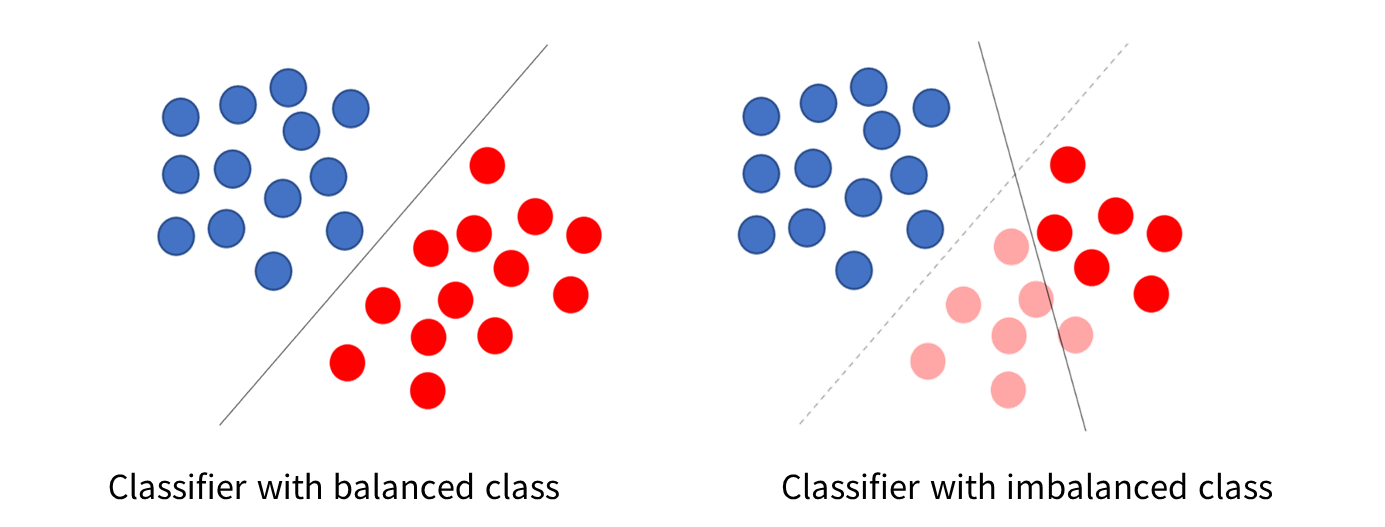

## 데이터 읽기

In [6]:
train = pd.read_csv('secom_nona_train1.csv')
test = pd.read_csv('secom_nona_test1.csv')

SECOM DATASET

- SECOM 데이터셋은 반도체 제조 공정에서 수집된 실제 데이터
- UCI Machine Learning Repository
- 데이터 개요
  - 특성(Feature) 수: 590개
  - 샘플 수: 1567개(각 관측치는 하나의 반도체 생산 사이클)
  - 대부분의 특성은 센서 측정값이나 공정 파라미터이나 마스킹 되어 있음
  - 클래스 정보
    - 1: 실패 (불량), 실습데이터 에서는 불량이 **1**
    - -1: 통과 (정상), 실습데이터에서는 정상이 **0**
  - 데이터 불균형:  불량 샘플이 매우 적음, 대부분 정상. 약 93%
  - 결측값: 일부 특성에 결측값이 존재(임의로 imputation 완료)
  - 고차원 데이터임



### 데이터 전처리

In [7]:
train.head(3)

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_582,x_583,x_584,x_585,x_586,x_587,x_588,x_589,target,datetime
0,3068.67,2517.04,2258.2778,2073.0764,1.2329,100.0,96.9478,0.1208,1.3524,0.0020,...,0.5024,0.0210,0.0045,4.1720,0.0276,0.0160,0.0053,57.7824,0,25/09/2008 10:23:00
1,2995.73,2515.83,2231.6111,2005.8966,1.2969,100.0,93.7522,0.1234,1.4136,0.0129,...,0.5011,0.0103,0.0027,2.0617,0.0090,0.0166,0.0047,183.3928,0,24/09/2008 10:10:00
2,2953.63,2384.04,2191.2111,1437.5003,2.2073,100.0,97.6444,0.1235,1.3584,-0.0024,...,0.4968,0.0188,0.0041,3.7853,0.0137,0.0326,0.0108,237.4625,0,03/10/2008 00:24:00


## 범주형 변수로 변환

In [8]:
## 시간 포맷 변경
train['datetime'] = pd.to_datetime(train['datetime'], format = "%d/%m/%Y %H:%M:%S")
test['datetime'] = pd.to_datetime( test['datetime'], format = "%d/%m/%Y %H:%M:%S")

## 시간 정보 따로 저장
train_time = train['datetime']
test_time = test['datetime']

## train/test 분리
X_train = train.drop(['datetime',  'target'], axis=1)
y_train = train['target']

X_test = test.drop(['datetime', 'target'], axis=1)
y_test = test['target']

### 데이터 확인

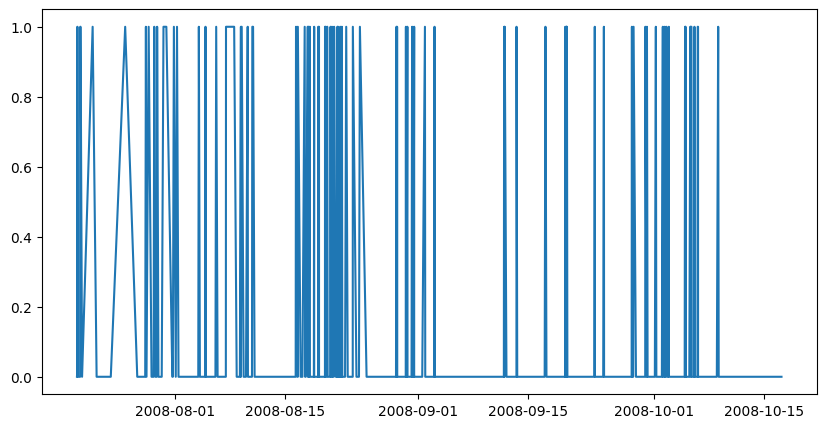

In [9]:
# train.sort_values(by = 'datetime')
plt.figure(figsize = (10, 5))
plt.plot(train.sort_values(by = 'datetime')['datetime'], train.sort_values(by = 'datetime')['target'])

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


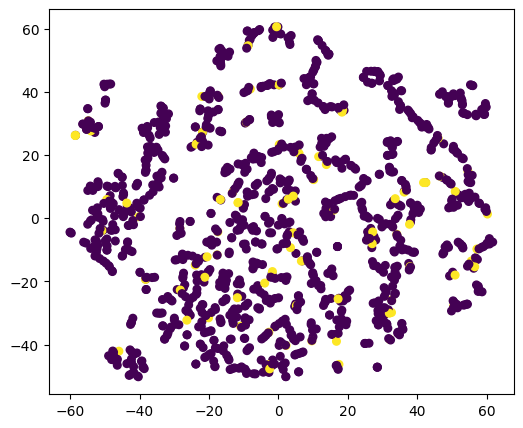

In [10]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2,
                          perplexity = 5,
                          learning_rate = 'auto',
                          init = 'pca',
                          n_iter = 600,
                          random_state = 1
            )
X_embedded = tsne.fit_transform(X_train)

plt.figure(figsize=(6, 5))
scatter = plt.scatter(X_embedded[:, 0],
                                        X_embedded[:, 1],
                                         c = y_train,  s = 30)
plt.show()


In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def custom_confusion_matrix(y_true, y_pred):

        ## 혼동 행렬 계산
        cm = confusion_matrix(y_true=y_true,
                                                          y_pred=y_pred)
        ## 클래스 1을 기준으로 행과 열 순서 변경
        cm = cm[::-1, ::-1]

        ## 행과 열을 바꾸기 위해 전치(transpose)
        cm_transposed = cm.T
        print(cm_transposed)


        # DataFrame으로 변환 (라벨 추가)
        df_cm = pd.DataFrame(cm_transposed,
                                                      index = ['pred 1', 'pred 0'],
                                                      columns = ['act 1', 'act 0'])

        ## 히트맵 그리기
        plt.figure(figsize = (4,3))
        sns.heatmap(df_cm, annot = True, fmt = 'd', cmap = 'Blues')
        plt.title('Confusion Matrix (Class 1 as Positive)')
        plt.ylabel('Predicted')
        plt.xlabel('Actual')
        plt.show()

## 기본 모델 결과

In [12]:
## 기본 모델
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
                                                          n_estimators = 100, # 기본값이 100
                                                          # criterion = 기본값은 'gini' , 'entropy', # 불균형에서는 entropy가 소수 클래스의 정보이득을 더 잘 반영할 수 있음
                                                          # class_weight = 기본값은 None, 'balanced_subsample', 'balanced',
                                                                # 작은 데이터셋 또는 균일한 클래스 분포를 유지하고 싶을 때: class_weight = 'balanced'
                                                                # 큰 데이터셋 또는 부트스트랩 샘플링의 변화에 민감하게 반응하고 싶을 때: class_weight = 'balanced_subsample'
                                                          random_state = 1,
                            )

rf.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [13]:
## 학습 결과
pred_rf = rf.predict(X_test)
pred_rf_proba = rf.predict_proba(X_test)[:, 1]

Without Sampling:
[[  0   0]
 [ 16 220]]


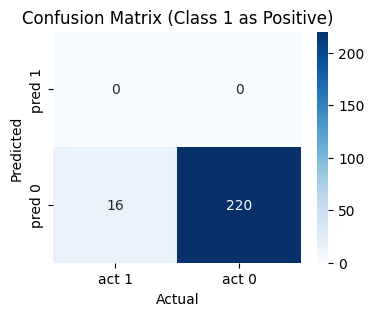

None


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,0,1,accuracy,macro avg,weighted avg
precision,0.932203,0.0,0.932203,0.466102,0.869003
recall,1.000000,0.0,0.932203,0.500000,0.932203
f1-score,0.964912,0.0,0.932203,0.482456,0.899494
support,220.000000,16.0,0.932203,236.000000,236.000000


In [14]:
## 혼동 행렬과 ROC 커브
print("Without Sampling:")

print(custom_confusion_matrix(y_test, pred_rf))

report_rf = classification_report(y_test, pred_rf, digits = 4,  output_dict = True)

report_rf = pd.DataFrame(report_rf)
rf_acc = report_rf['accuracy'].iloc[0]
rf_f1_macro = report_rf['macro avg']['f1-score']
rf_f1_weighted = report_rf['weighted avg']['f1-score']

report_rf

Classification Report 해석하기1
- macro average
  - 클래스 불균형이 있는 데이터에서 소수 클래스에 대한 성능을 강조하고자 할 때
  - 단순 평균
- weighted average
  - 전체적인 모델 성능을 평가 할 때
  - 클래스 비중을 고려한 평균

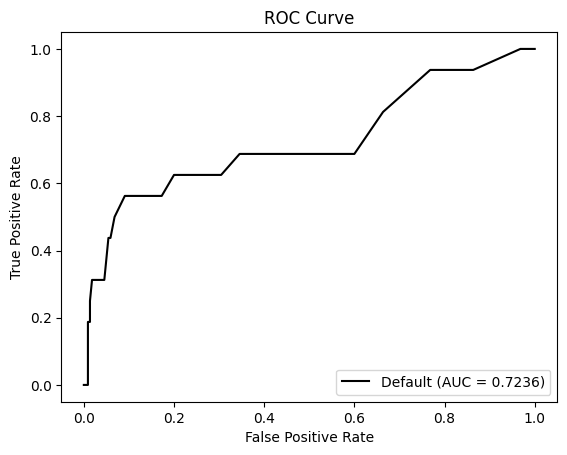

roc_auc: 
0.7235795454545454


In [15]:
fpr, tpr, _ = roc_curve(y_test, pred_rf_proba)
plt.plot(fpr, tpr,
                 label  = 'Default (AUC = {:.4f})'. format(auc(fpr, tpr)),
                 color = 'black')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc = 'lower right')
plt.show()

roc_auc = auc(fpr, tpr)
print('roc_auc: ')
print(roc_auc)

## 오버샘플링

In [16]:
from imblearn.over_sampling import RandomOverSampler

## 오버샘플링 (Over Sampling)
ros = RandomOverSampler( # 객체 생성
    sampling_strategy  = 'auto', # 소수클래스 오버샘플링 비율, 기본값 'auto',
    # sampling_strategy = 0.3, # 소수 클래스의 샘플 수가 다수 클래스의 샘플 수의 이 비율에 도달하도록 생성
    random_state = 1
)

X_train_over, y_train_over = ros.fit_resample(X_train, y_train)

In [17]:
y_train_over.value_counts()

,count
target,
0,1243
1,1243


In [18]:
pd.Series(y_train).value_counts()

,count
target,
0,1243
1,88


In [19]:
## 오버샘플링 데이터에 적용
rf = RandomForestClassifier(
                                            n_estimators = 100,
                                            random_state = 1,
)

rf.fit(X_train_over, y_train_over)

RandomForestClassifier(random_state=1)

In [20]:
## 학습 결과
pred_rf_over = rf.predict(X_test)
pred_rf_proba_over = rf.predict_proba(X_test)[:, 1]

Oversampling:
[[  0   0]
 [ 16 220]]


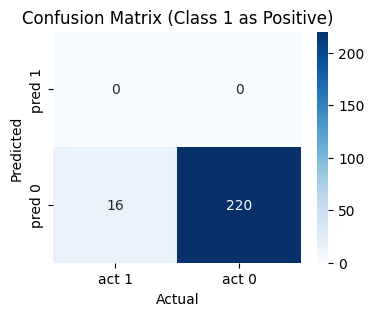

None


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,0,1,accuracy,macro avg,weighted avg
precision,0.932203,0.0,0.932203,0.466102,0.869003
recall,1.000000,0.0,0.932203,0.500000,0.932203
f1-score,0.964912,0.0,0.932203,0.482456,0.899494
support,220.000000,16.0,0.932203,236.000000,236.000000


In [21]:
## 혼동 행렬과 ROC 커브
print("Oversampling:")

print(custom_confusion_matrix(y_test, pred_rf_over))

report_rf_over = classification_report(y_test, pred_rf_over, digits = 4,  output_dict = True)

report_rf_over = pd.DataFrame(report_rf_over)
rf_acc_over = report_rf_over['accuracy'].iloc[0]
rf_f1_macro_over = report_rf_over['macro avg']['f1-score']
rf_f1_weighted_over = report_rf_over['weighted avg']['f1-score']


report_rf_over


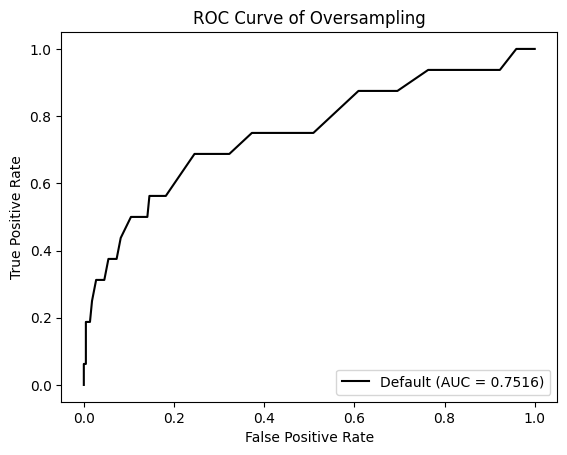

roc_auc: 
0.7515625000000001


In [22]:
fpr, tpr, _ = roc_curve(y_test, pred_rf_proba_over)
plt.plot(fpr, tpr,
                 label  = 'Default (AUC = {:.4f})'. format(auc(fpr, tpr)),
                 color = 'black')
plt.title("ROC Curve of Oversampling")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc = 'lower right')
plt.show()

roc_auc = auc(fpr, tpr)
print('roc_auc: ')
print(roc_auc)

## 언더샘플링

In [23]:
from imblearn.under_sampling import RandomUnderSampler

## 언더샘플링 (Under Sampling)
rus = RandomUnderSampler(
    sampling_strategy  = 'auto', # 다수클래스 언더샘플링 비율,
    # sampling_strategy = 0.3, # 다수 클래스의 샘플 수가 소수 클래스의 샘플수의 이 비율에 도달하도록 생성
    random_state = 1
)

X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

In [24]:
y_train_under.value_counts()

,count
target,
0,88
1,88


In [25]:
pd.Series(y_train).value_counts()

,count
target,
0,1243
1,88


In [26]:
## 언더샘플링 데이터로 적용
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
                                                            n_estimators = 100,
                                                            random_state = 1,

    )

rf.fit(X_train_under, y_train_under)

pred_rf_under = rf.predict(X_test)
pred_rf_proba_under = rf.predict_proba(X_test)[:, 1]

Under Sampling:
[[ 12  73]
 [  4 147]]


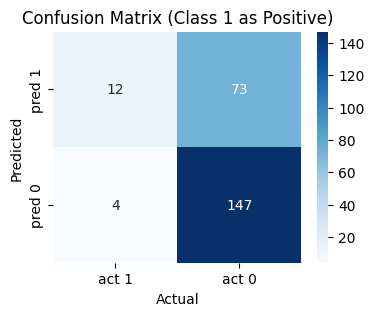

None


,0,1,accuracy,macro avg,weighted avg
precision,0.973510,0.141176,0.673729,0.557343,0.917081
recall,0.668182,0.750000,0.673729,0.709091,0.673729
f1-score,0.792453,0.237624,0.673729,0.515038,0.754837
support,220.000000,16.000000,0.673729,236.000000,236.000000


In [27]:
## 혼동 행렬과 ROC 커브
print("Under Sampling:")

print(custom_confusion_matrix(y_test, pred_rf_under))

report_rf_under = classification_report(y_test, pred_rf_under, digits = 4,  output_dict = True)

report_rf_under = pd.DataFrame(report_rf_under)
rf_acc_under = report_rf_under['accuracy'].iloc[0]
rf_f1_macro_under = report_rf_under['macro avg']['f1-score']
rf_f1_weighted_under = report_rf_under['weighted avg']['f1-score']


report_rf_under

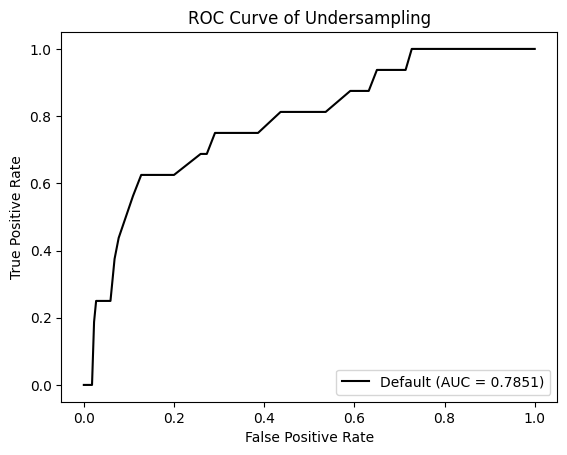

roc_auc: 
0.7850852272727272


In [28]:
fpr, tpr, _ = roc_curve(y_test, pred_rf_proba_under)
plt.plot(fpr, tpr,
                 label  = 'Default (AUC = {:.4f})'. format(auc(fpr, tpr)),
                 color = 'black')
plt.title("ROC Curve of Undersampling")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc = 'lower right')
plt.show()

roc_auc = auc(fpr, tpr)
print('roc_auc: ')
print(roc_auc)

## SMOTE

In [29]:
from imblearn.over_sampling import SMOTE

## SMOTE 적용
smote = SMOTE(
                   # sampling_strategy = 'auto', # 소수클래스 오버샘플링 비율, 기본값 'auto',
                   # sampling_strategy = 0.3, # 소수클래스 오버샘플링 비율, 기본값 'auto',
                    k_neighbors = 2, # 불균형이 심하면 작은 값을 추천, 기본값은 5
                    random_state = 123,

)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

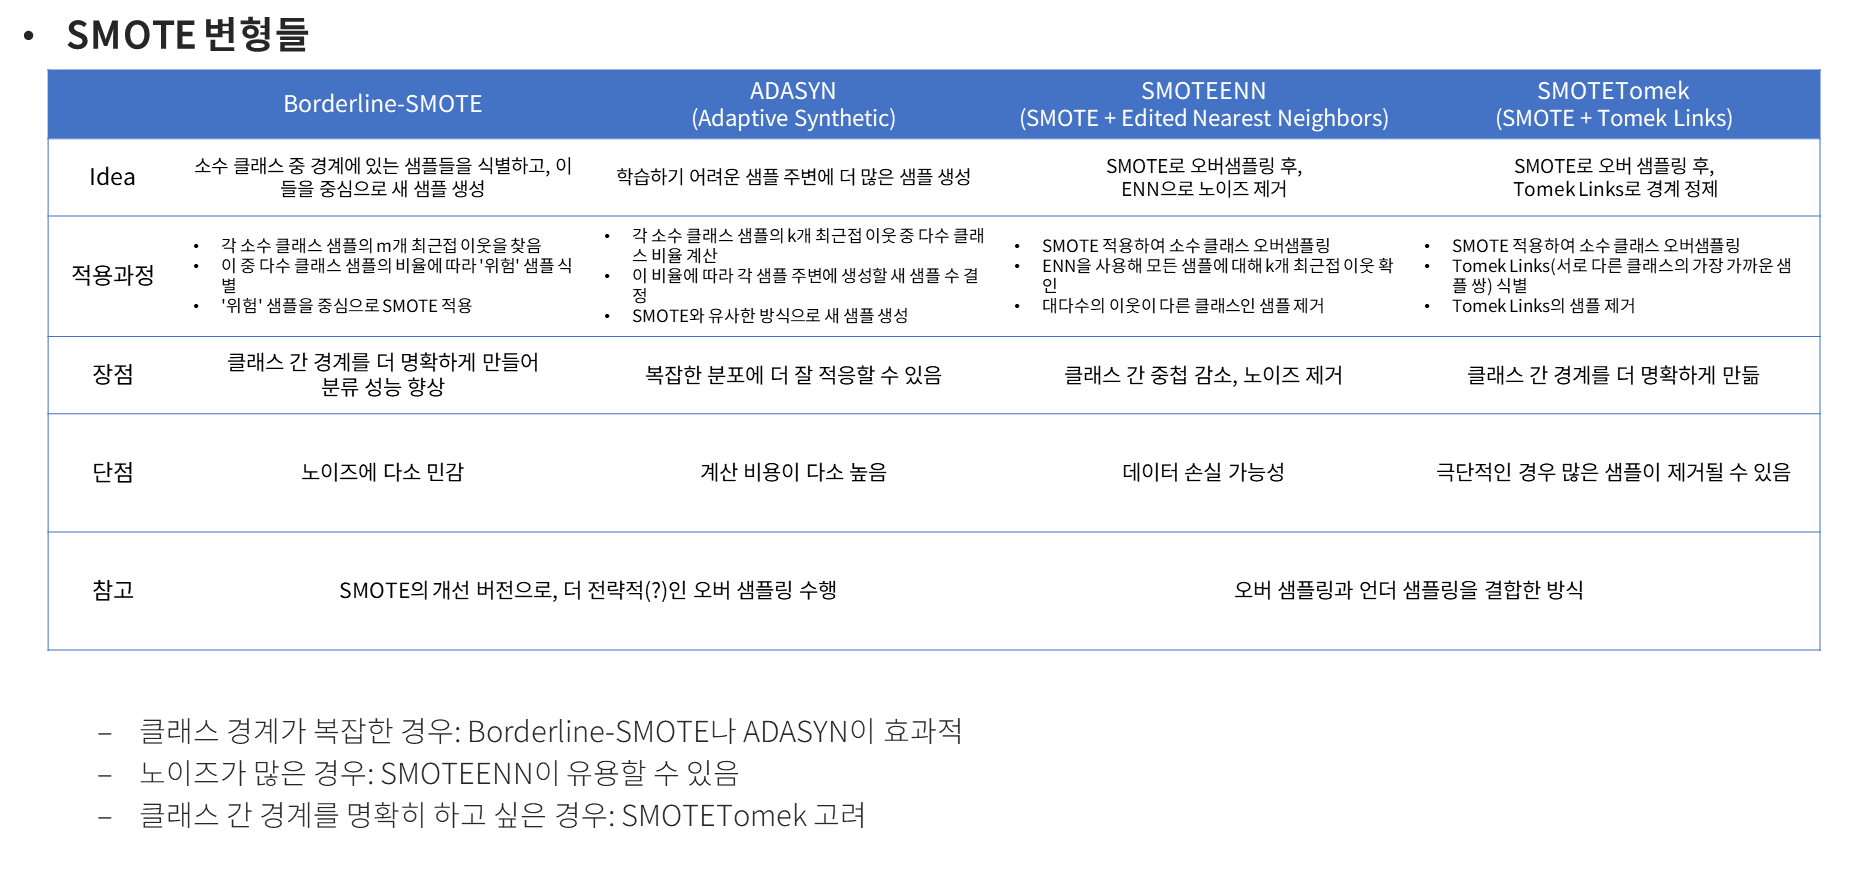

In [30]:
# from imblearn.over_sampling import BorderlineSMOTE

# ## Borderline-SMOTE 적용
# smote2 = BorderlineSMOTE(
#                          # kind =  'borderline-1',
#                          random_state = 1
#                                )
# X_train_smote2, y_train_smote2 = smote2.fit_resample(X_train,   y_train)

In [31]:
y_train_smote.value_counts()

,count
target,
0,1243
1,1243


In [32]:
pd.Series(y_train).value_counts()

,count
target,
0,1243
1,88


In [33]:
## SMOTE 데이터에 적용

rf = RandomForestClassifier(
                           n_estimators = 100,
                           random_state = 1,
                            )

rf.fit(X_train_smote, y_train_smote)

pred_rf_smote = rf.predict(X_test)
pred_rf_proba_smote = rf.predict_proba(X_test)[:, 1]

SMOTE:
[[  1   0]
 [ 15 220]]


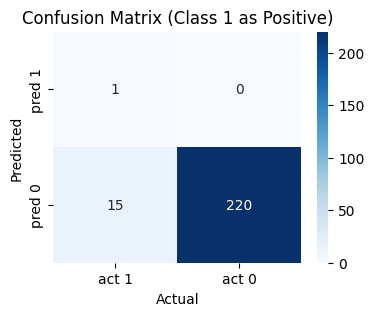

None


,0,1,accuracy,macro avg,weighted avg
precision,0.936170,1.000000,0.936441,0.968085,0.940498
recall,1.000000,0.062500,0.936441,0.531250,0.936441
f1-score,0.967033,0.117647,0.936441,0.542340,0.909447
support,220.000000,16.000000,0.936441,236.000000,236.000000


In [34]:
## 혼동 행렬과 ROC 커브
print("SMOTE:")

print(custom_confusion_matrix(y_test, pred_rf_smote))

report_rf_smote = classification_report(y_test,  pred_rf_smote,  digits = 4,  output_dict = True)

report_rf_smote = pd.DataFrame(report_rf_smote)
rf_acc_smote = report_rf_smote['accuracy'].iloc[0]
rf_f1_macro_smote = report_rf_smote['macro avg']['f1-score']
rf_f1_weighted_smote = report_rf_smote['weighted avg']['f1-score']

report_rf_smote

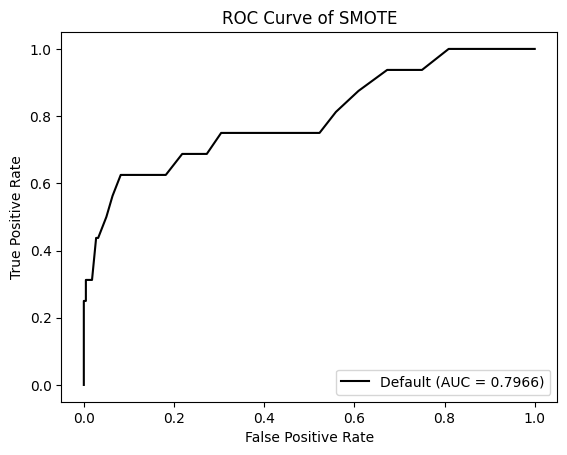

roc_auc: 
0.7965909090909091


In [35]:
fpr, tpr, _ = roc_curve(y_test, pred_rf_proba_smote)
plt.plot(fpr, tpr,
                 label  = 'Default (AUC = {:.4f})'. format(auc(fpr, tpr)),
                 color = 'black')
plt.title("ROC Curve of SMOTE")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc = 'lower right')
plt.show()

roc_auc = auc(fpr, tpr)
print('roc_auc: ')
print(roc_auc)

## 결과 비교

In [36]:
## 결과 비교
comparison_df = pd.DataFrame({
                                        'Model': ['RF',
                                                           'RF_over',
                                                           'RF_under',
                                                           'RF_smote'],
                                        'Accuracy': [
                                          rf_acc,
                                          rf_acc_over,
                                          rf_acc_under,
                                          rf_acc_smote
                                        ],
                                        'f1-score_macro': [
                                            rf_f1_macro,
                                            rf_f1_macro_over,
                                            rf_f1_macro_under,
                                            rf_f1_macro_smote,
                                        ],
                                        'f1-score_weighted': [
                                            rf_f1_weighted,
                                            rf_f1_weighted_over,
                                            rf_f1_weighted_under,
                                            rf_f1_weighted_smote,
                                        ]
                                  })

comparison_df

,Model,Accuracy,f1-score_macro,f1-score_weighted
0,RF,0.932203,0.482456,0.899494
1,RF_over,0.932203,0.482456,0.899494
2,RF_under,0.673729,0.515038,0.754837
3,RF_smote,0.936441,0.542340,0.909447


Classification Report 해석하기2  

- weighted average >= macro > micro
- macro average(소수클래스가 중요할때)
  - 각 클래스의 F1-score를 모두 같은 가중치로 평균낸 값
    - 모든 클래스가 동일하게 중요할때
    - 소수 클래스의 성능이 특히 중요할 때
   - 클래스 크기(샘플 수)와 상관없이 모든 클래스를 똑같이 평가

- **weighted average(가장 일반적)**
  - 각 클래스의 F1-score에 해당 클래스의 샘플 수를 가중치평균한 값
    - 전체적인 모델 성능을 평가하면서 클래스 불균형을 고려할 때
    - 클래스의 샘플 수를 반영하여 평가
    - 다수 클래스의 영향이 크지만, 소수 클래스의 성능도 일부 반영됨

- micro average
    - 모든 클래스의 예측 결과(TP, TF, FP, FN)를 합쳐서 계산한 F1-score
     - 전체적인 성능을 한 번에 평가할 때
클래스 불균형이 별로 없는 경우 사용
     - 모든 데이터를 하나의 집합으로 취급하여 평가
     - 다수 클래스의 성능이 더 많이 반영됨




**Macro vs. Weighted F1-score**

- Macro F1-score
  - 모든 클래스의 성능이 중요하지만, 소수 클래스의 성능이 상대적으로 더 중요할 때
  - 의료 진단이나 사기 탐지와 같이 소수 클래스를 정확히 예측하는 것이 매우 중요한 경우

- Weighted F1-score
  - 모델의 전반적인 성능을 평가하고 싶을 때
  - 특히 클래스의 크기 차이가 클 때 성능 평가에 적합
  - 일반적인 분류 문제에서 모든 클래스의 예측 성능을 클래스 크기에 따라 비율적으로 평가하고자 할 때


In [37]:
# EOS